In [1]:
%pylab inline
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from aif360.datasets import AdultDataset

plt.style.use("ggplot")
sns.set(style="white")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import aif360
print(aif360.__version__)

0.2.3


We load the `AdultDataset` and use it as if it was a new dataset.

In [3]:
data, _metadata = AdultDataset().convert_to_dataframe(de_dummy_code=True, set_category=True)

/usr/local/lib/python3.6/site-packages/aif360/datasets/standard_dataset.py:121: FutureWarning: outer method for ufunc <ufunc 'equal'> is not implemented on pandas objects. Returning an ndarray, but in the future this will raise a 'NotImplementedError'. Consider explicitly converting the Series to an array with '.array' first.
  priv = np.logical_or.reduce(np.equal.outer(vals, df[attr]))
/usr/local/lib/python3.6/site-packages/aif360/datasets/standard_dataset.py:142: FutureWarning: outer method for ufunc <ufunc 'equal'> is not implemented on pandas objects. Returning an ndarray, but in the future this will raise a 'NotImplementedError'. Consider explicitly converting the Series to an array with '.array' first.
  df[label_name]))


In [4]:
data.head()

,age,education-num,race,sex,capital-gain,capital-loss,hours-per-week,income-per-year,workclass,education,marital-status,occupation,relationship,native-country
0,39.0,13.0,White,Male,2174.0,0.0,40.0,<=50K,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,United-States
1,50.0,13.0,White,Male,0.0,0.0,13.0,<=50K,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,United-States
2,38.0,9.0,White,Male,0.0,0.0,40.0,<=50K,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,United-States
3,53.0,7.0,Non-white,Male,0.0,0.0,40.0,<=50K,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,United-States
4,28.0,13.0,Non-white,Female,0.0,0.0,40.0,<=50K,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Cuba


## Data Exploration

### Race

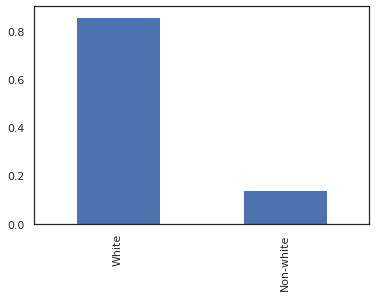

In [5]:
data["race"].value_counts(normalize=True).plot.bar()

### Sex

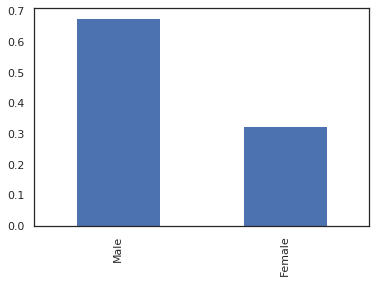

In [6]:
data["sex"].value_counts(normalize=True).plot.bar()

### Age

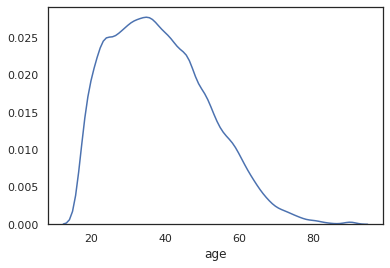

In [7]:
sns.distplot(data["age"], hist=False)

### Education Num

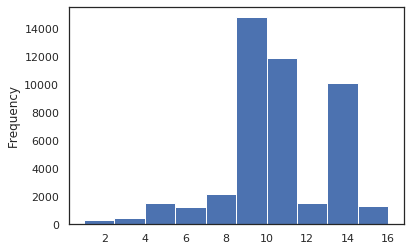

In [8]:
data["education-num"].plot.hist()

### Income per year

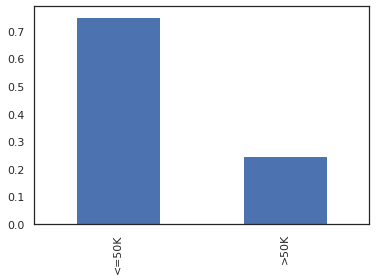

In [9]:
data["income-per-year"].value_counts(normalize=True).plot.bar()

### Marital Status

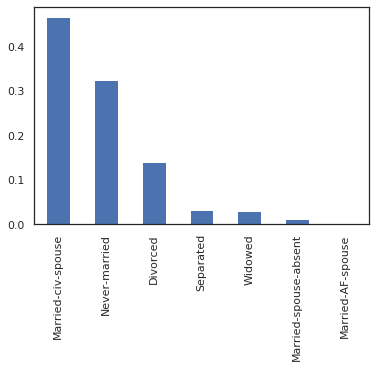

In [10]:
data["marital-status"].value_counts(normalize=True).plot.bar()

### Native country

In [11]:
data["native-country"].value_counts()

United-States                 41292
Mexico                          903
Philippines                     283
Germany                         193
Puerto-Rico                     175
Canada                          163
El-Salvador                     147
India                           147
Cuba                            133
England                         119
China                           113
Jamaica                         103
South                           101
Italy                           100
Dominican-Republic               97
Japan                            89
Guatemala                        86
Vietnam                          83
Columbia                         82
Poland                           81
Haiti                            69
Portugal                         62
Iran                             56
Taiwan                           55
Greece                           49
Nicaragua                        48
Peru                             45
Ecuador                     

## Original Bias

We will first identify whether there is any bias in the way the income is distributed. We will then try to build a classifier without any anti-bias techniques and evaluate whether this model has bias.

We first start by creating a `Dataset`

In [12]:
from aif360.datasets import StandardDataset

def custom_preprocessing(df):
    df = df.copy()
    
    df["native-country"] = df["native-country"].astype(str)
    
    return df

ds = StandardDataset(
    data, 
    label_name="income-per-year", favorable_classes=[">50K", ">50K", ">50K", ">50K"],
    protected_attribute_names=["age", "race", "sex", "native-country"],
    privileged_classes=[lambda a: a > 30, ["White"], ["Male"], ["United-States", "England"]],
    categorical_features=['workclass','education','marital-status','occupation','relationship'],
    custom_preprocessing=custom_preprocessing
)

Now that we have the dataset in the `aif360` format, we can use it to compute the bias metrics.

In [13]:
from aif360.metrics import BinaryLabelDatasetMetric

privileged_groups = [dict(zip(ds.protected_attribute_names, ds.privileged_protected_attributes))]
unprivileged_groups = [{n: v} for n, v in zip(ds.protected_attribute_names, ds.unprivileged_protected_attributes)]

metrics = BinaryLabelDatasetMetric(
    ds,
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups,
)

#### Individual Fairness

\begin{equation*}
1 - \frac{1}{n\cdot\text{n_neighbors}}\sum_{i=1}^n |\hat{y}_i - \sum_{j\in\mathcal{N}_{\text{n_neighbors}}(x_i)} \hat{y}_j|
\end{equation*}

In [14]:
metrics.consistency()

/usr/local/lib64/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


array([0.84270046])

#### Disparate impact

\begin{equation*}
\frac{\mathbb{P}(Y = 1 | Z = \text{unprivileged})}
   {\mathbb{P}(Y = 1 | Z = \text{privileged})}
\end{equation*}

In [15]:
metrics.disparate_impact()

0.3057589241172194

#### Parity difference

\begin{equation*}
\mathbb{P}(Y = 1 | Z = \text{unprivileged}) - \mathbb{P}(Y = 1 | Z = \text{privileged})
\end{equation*}

In [16]:
metrics.statistical_parity_difference()

-0.29242515580201855

## Model Bias

We now build a simple classifier and evaluate how bias the results are.

              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91     34014
         1.0       0.79      0.59      0.68     11208

    accuracy                           0.86     45222
   macro avg       0.84      0.77      0.80     45222
weighted avg       0.86      0.86      0.85     45222



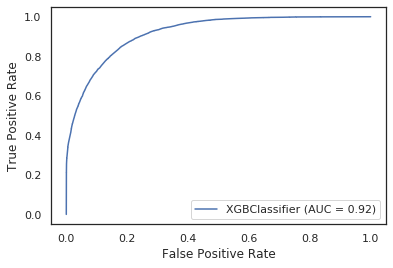

In [17]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_roc_curve

model = XGBClassifier()

y = ds.scores.ravel()
X = ds.features

model.fit(X, y)

y_hat = model.predict(X)

print(classification_report(y, y_hat))

plot_roc_curve(model, X, y)

In [18]:
data_hat = data.copy()
data_hat["income-per-year"] = pd.Series(y_hat, index=data.index).apply(lambda v: ">50K" if v else "<=50K")
ds_hat = StandardDataset(
    data_hat, 
    label_name="income-per-year", favorable_classes=[">50K", ">50K", ">50K", ">50K"],
    protected_attribute_names=["age", "race", "sex", "native-country"],
    privileged_classes=[lambda a: a > 30, ["White"], ["Male"], ["United-States", "England"]],
    categorical_features=['workclass','education','marital-status','occupation','relationship'],
    custom_preprocessing=custom_preprocessing
)

/usr/local/lib/python3.6/site-packages/aif360/datasets/standard_dataset.py:121: FutureWarning: outer method for ufunc <ufunc 'equal'> is not implemented on pandas objects. Returning an ndarray, but in the future this will raise a 'NotImplementedError'. Consider explicitly converting the Series to an array with '.array' first.
  priv = np.logical_or.reduce(np.equal.outer(vals, df[attr]))
/usr/local/lib/python3.6/site-packages/aif360/datasets/standard_dataset.py:142: FutureWarning: outer method for ufunc <ufunc 'equal'> is not implemented on pandas objects. Returning an ndarray, but in the future this will raise a 'NotImplementedError'. Consider explicitly converting the Series to an array with '.array' first.
  df[label_name]))


In [19]:
from aif360.metrics import ClassificationMetric

classification_metrics = ClassificationMetric(
    ds, ds_hat, 
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups
)

In [20]:
classification_metrics.performance_measures()

{'TPR': 0.5930585296216988,
 'TNR': 0.9494031869230317,
 'FPR': 0.050596813076968304,
 'FNR': 0.4069414703783012,
 'GTPR': 0.5930585296216988,
 'GTNR': 0.9494031869230317,
 'GFPR': 0.050596813076968304,
 'GFNR': 0.4069414703783012,
 'PPV': 0.7943355640535373,
 'NPV': 0.8762413849242958,
 'FDR': 0.20566443594646272,
 'FOR': 0.12375861507570413,
 'ACC': 0.8610853124585379}

#### Accuracy

In [21]:
classification_metrics.accuracy()

0.8610853124585379

#### Average Absolute Odds Difference

\begin{equation*}
\tfrac{1}{2}\left[|FPR_{Z = \text{unprivileged}} - FPR_{Z = \text{privileged}}| + |TPR_{Z = \text{unprivileged}} - TPR_{Z = \text{privileged}}|\right]
\end{equation*}

In [22]:
classification_metrics.average_abs_odds_difference()

0.11944084068929571

#### Avereage Odds Difference

\begin{equation*}
\tfrac{1}{2}\left[(FPR_{Z = \text{unprivileged}} - FPR_{Z = \text{privileged}}) + (TPR_{Z = \text{unprivileged}} - TPR_{Z = \text{privileged}}))\right]
\end{equation*}

In [23]:
classification_metrics.average_odds_difference()

-0.11944084068929571

In [24]:
classification_metrics.between_group_theil_index()

0.00017833785627120814